In [151]:
import re
import numpy as np
import math
import matplotlib.pyplot as plt

mu_sol = 1.32712440018e11  # km^3/s^2

In [152]:
def read_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê o arquivo de dados e retorna todos os parâmetros para uma data específica
    
    Args:
        date (str): Data no formato 'ano-Mes-dia'
        filename (str): Nome do arquivo de dados
    
    Returns:
        dict: Dicionário com todos os parâmetros orbitais
    """
    
    with open(filename, 'r') as file:
        content = file.read()
    
    pattern = rf'(\d+\.\d+) = A\.D\. {date}.*?(?=\n\d+\.\d+ = A\.D\.|\Z)'
    match = re.search(pattern, content, re.DOTALL)
    
    if not match:
        raise ValueError(f"Data {date} não encontrada no arquivo")
    
    block = match.group(0)
    
    params = {}
    
    jd_match = re.search(r'(\d+\.\d+) = A\.D\.', block)
    if jd_match:
        params['JDTDB'] = float(jd_match.group(1))
    
    param_pattern = r'([A-Za-z]+)\s*=\s*([-+]?\s*\d*\.?\d+(?:[Ee][-+]?\d+)?)'
    matches = re.findall(param_pattern, block)
    
    for key, value in matches:
        value_clean = re.sub(r'\s+', '', value)
        params[key] = float(value_clean)
    
    return params


In [153]:
def print_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê e imprime todos os parâmetros para uma data específica
    """
    parametros = read_parameters(date, filename)
    
    print(f"Parâmetros orbitais para {date}:")
    print("=" * 50)
    
    # Lista de todos os parâmetros na ordem desejada
    parametros_info = [
        ('JDTDB', 'Julian Day Number, Barycentric Dynamical Time'),
        ('EC', 'Eccentricity, e'),
        ('QR', 'Periapsis distance, q (km)'),
        ('IN', 'Inclination w.r.t X-Y plane, i (degrees)'),
        ('OM', 'Longitude of Ascending Node, OMEGA, (degrees)'),
        ('W', 'Argument of Perifocus, w (degrees)'),
        ('Tp', 'Time of periapsis (Julian Day Number)'),
        ('N', 'Mean motion, n (degrees/sec)'),
        ('MA', 'Mean anomaly, M (degrees)'),
        ('TA', 'True anomaly, nu (degrees)'),
        ('A', 'Semi-major axis, a (km)'),
        ('AD', 'Apoapsis distance (km)'),
        ('PR', 'Sidereal orbit period (sec)')
    ]
    
    for key, description in parametros_info:
        if key in parametros:
            if key == 'JDTDB':
                print(f"{key:4} = {parametros[key]:.6f} # {description}")
            else:
                print(f"{key:4} = {parametros[key]:.15e} # {description}")
        else:
            print(f"{key:4} = NÃO ENCONTRADO # {description}")

In [154]:
def excentricity(r1, theta1, r2, theta2):
    return abs((r2 - r1) / (r1*np.cos(theta1) - r2*np.cos(theta2)))

def semiaxis(r, e, theta):
    return r * (1 + e * np.cos(theta)) / (1 - e**2)

def angular_momentum(r, theta, e, mu):
    return np.sqrt(mu * r * (1 + e * np.cos(theta)))

def tangencial_velocity(mu, h, e, theta):
    return mu / h * (1 + e * np.cos(theta))

def radial_velocity(mu, h, e, theta):
    return mu / h * e * np.sin(theta)

def velocity_magnitude(mu, h, e, theta):
    return mu / h * np.sqrt(e**2 + 2*e*np.cos(theta) + 1)

In [155]:
def eccentric_anomaly_from_mean_anomaly(M,e):
    error = 1
    E = M
    while error > 1e-10:
        E_new = E - (E - e * math.sin(E) - M) / (1 - e * math.cos(E))
        error = abs((E_new - E)/E_new)
        E = E_new
    return E

def eccentric_anomaly_from_true_anomaly(theta, e):
    return 2 * math.atan( math.tan(theta / 2) / math.sqrt((1 + e) / (1 - e)) )

def mean_anomaly_from_eccentric_anomaly(E, e):
    return E - e * math.sin(E)

def orbital_period(a, mu):
    return 2 * math.pi * math.sqrt(a**3 / mu)

def time_from_periapsis(theta, e, a, mu):
    E = eccentric_anomaly_from_true_anomaly(theta, e)
    M = mean_anomaly_from_eccentric_anomaly(E, e)
    T = orbital_period(a, mu)
    return M * T / (2 * math.pi)

def calculate_travel_time(theta1, theta2, e, a, mu):
    """
    Calcula o tempo para viajar de theta1 a theta2 em uma órbita elíptica
    """
    t1 = time_from_periapsis(theta1, e, a, mu)
    t2 = time_from_periapsis(theta2, e, a, mu)
    
    # Se theta2 < theta1, assumimos que completou uma órbita
    if theta2 < theta1:
        T = orbital_period(a, mu)
        return ((T - t1) + t2) / (60*60*24)  # Retorna em dias
    else:
        return (t2 - t1) / (60*60*24)  # Retorna em dias

In [156]:
def plot_orbit(e, a, theta1, theta2, r1, r2):
    """
    Ta bem ruim o plot

    Plota a órbita elíptica com a parte percorrida em linha contínua
    
    Args:
        e: excentricidade
        a: semi-eixo maior (km)
        theta1, theta2: anomalias verdadeiras inicial e final (graus)
        r1, r2: raios orbital inicial e final (km)
    """
    
    # Parâmetros da elipse
    b = a * np.sqrt(1 - e**2)  # semi-eixo menor
    c = e * a  # distância do centro ao foco
    
    # Gera pontos para a órbita completa
    theta_full = np.linspace(0, 2*np.pi, 1000)
    r_full = a * (1 - e**2) / (1 + e * np.cos(theta_full))
    
    # Converte para coordenadas cartesianas
    x_full = r_full * np.cos(theta_full)
    y_full = r_full * np.sin(theta_full)
    
    # Gera pontos para a parte percorrida
    if theta2 > theta1:
        theta_traveled = np.linspace(theta1, theta2, 200)
    else:
        # Se theta2 < theta1, assumimos que passa pelo periastro
        theta_traveled = np.concatenate([
            np.linspace(theta1, 2*np.pi, 100),
            np.linspace(0, theta2, 100)
        ])
    
    r_traveled = a * (1 - e**2) / (1 + e * np.cos(theta_traveled))
    x_traveled = r_traveled * np.cos(theta_traveled)
    y_traveled = r_traveled * np.sin(theta_traveled)
    
    # Cria a figura
    plt.figure(figsize=(10, 8))
    
    # Plot da órbita completa (tracejada)
    plt.plot(x_full, y_full, '--', color='gray', alpha=0.7, label='Órbita completa')
    
    # Plot da parte percorrida (contínua)
    plt.plot(x_traveled, y_traveled, '-', color='blue', linewidth=2, label='Trajetória percorrida')
    
    # Marca as posições inicial e final
    plt.plot(r1 * np.cos(theta1), r1 * np.sin(theta1), 'go', 
             markersize=8, label=f'Início (θ={theta1:.1f}°)')
    plt.plot(r2 * np.cos(theta2), r2 * np.sin(theta2), 'ro', 
             markersize=8, label=f'Fim (θ={theta2:.1f}°)')
    
    # Marca o Sol no foco
    plt.plot(0, 0, 'yo', markersize=15, label='Sol')
    plt.plot(0, 0, 'y*', markersize=20)
    
    # Marca o periastro e apoastro
    periastro = a * (1 - e)
    apoastro = a * (1 + e)
    
    plt.plot([-c, -c], [0, 0], 'kx', markersize=8, label='Centro')
    plt.plot([-c + a, -c - a], [0, 0], 'k--', alpha=0.3)  # Linha do semi-eixo maior
    
    # Configurações do gráfico
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title(f'Órbita Cassini - {date1} a {date2}\n'
              f'e = {e:.4f}, a = {a/1e6:.1f}×10⁶ km')
    plt.legend()
    
    # Adiciona informações textuais
    textstr = f'Δθ = {theta2 - theta1:.1f}°\n' \
              f'r₁ = {r1/1e6:.1f}×10⁶ km\n' \
              f'r₂ = {r2/1e6:.1f}×10⁶ km\n' \
              f'Periastro = {periastro/1e6:.1f}×10⁶ km\n' \
              f'Apoastro = {apoastro/1e6:.1f}×10⁶ km'
    
    plt.annotate(textstr, xy=(0.02, 0.98), xycoords='axes fraction',
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Ajusta os limites para melhor visualização
    max_range = max(apoastro, np.max(np.abs(x_full)), np.max(np.abs(y_full)))
    # plt.xlim(-max_range*1.1, max_range*1.1)
    # plt.ylim(-max_range*1.1, max_range*1.1)
    
    plt.tight_layout()
    plt.show()

In [157]:
def dados_da_orbita(start, finish, printa_dados=False, plota_orbita=False):
    
    data1 = read_parameters(start)
    data2 = read_parameters(finish)

    theta1 = np.radians(data1['TA'])
    theta2 = np.radians(data2['TA'])
    r1 = data1['A'] * (1 - data1['EC']**2) / (1 + data1['EC'] * np.cos(theta1))
    r2 = data2['A'] * (1 - data2['EC']**2) / (1 + data2['EC'] * np.cos(theta2))

    e = excentricity(r1, theta1, r2, theta2)
    a = semiaxis(r1, e, theta1)
    h = angular_momentum(r1, theta1, e, mu_sol)
    vr1 = radial_velocity(mu_sol, h, e, theta1)
    vt1 = tangencial_velocity(mu_sol, h, e, theta1)
    v1 = velocity_magnitude(mu_sol, h, e, theta1)
    vr2 = radial_velocity(mu_sol, h, e, theta2)
    vt2 = tangencial_velocity(mu_sol, h, e, theta2)
    v2 = velocity_magnitude(mu_sol, h, e, theta2)
    real_time = (data2['JDTDB'] - data1['JDTDB']) # em dias
    theoretical_time = calculate_travel_time(theta1, theta2, e, a, mu_sol)
    erro_percentual = abs((theoretical_time - real_time) / real_time) * 100

    if printa_dados:
        print()
        print(f"Parâmetros calculados entre {start} e {finish}:")
        print("=" * 50)
        print(f"Excentricidade: {e:.15e}")
        print(f"Semi-eixo maior:{a:.15e} km ")
        print(f"Momento angular: {h:.15e} km^2/s ")
        print(f"Velocidade inicial {start}: vr = {vr1:.15e} km/s, vt = {vt1:.15e} km/s, v_total = {v1:.15e} km/s")
        print(f"Velocidade final {finish}: vr = {vr2:.15e} km/s, vt = {vt2:.15e} km/s, v_total = {v2:.15e} km/s")
        print(f"Tempo real de viagem: {real_time:.6f} dias")
        print(f"Tempo teórico de viagem: {theoretical_time:.6f} dias")
        print(f"Erro percentual: {erro_percentual:.6f} %")
        print("=" * 50)
        print()

    if plota_orbita:
        plot_orbit(e, a, theta1, theta2, r1, r2)

    return {
        'e': e,
        'a': a,
        'h': h,
        'vr_start': vr1,
        'vt_start': vt1,
        'v_start': v1,
        'vr_end': vr2,
        'vt_end': vt2,
        'v_end': v2,
        'real_time_days': real_time,
        'theoretical_time_days': theoretical_time,
        'error_percent': erro_percentual
    }


Parâmetros calculados entre 1997-Oct-16 e 1998-Apr-26:
Excentricidade: 2.002756805174427e-01
Semi-eixo maior:1.260206367640563e+08 km 
Momento angular: 4.006704435119906e+09 km^2/s 
Velocidade inicial 1997-Oct-16: vr = 2.126285278130054e+00 km/s, vt = 2.683894581596388e+01 km/s, v_total = 2.692304034830088e+01 km/s
Velocidade final 1998-Apr-26: vr = 5.439031185389663e+00 km/s, vt = 3.692025668766812e+01 km/s, v_total = 3.731874078956770e+01 km/s
Tempo real de viagem: 192.000000 dias
Tempo teórico de viagem: 192.263453 dias
Erro percentual: 0.137215 %



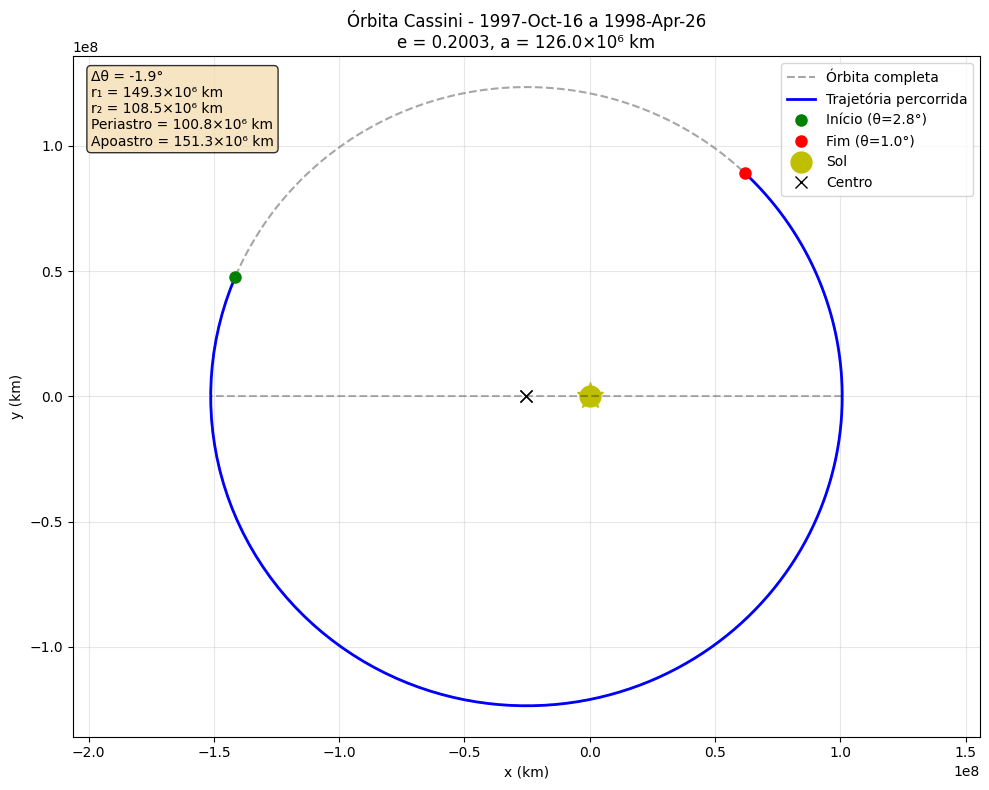

In [ ]:
orbita1 = dados_da_orbita('1997-Oct-16', '1998-Apr-26', printa_dados=True, plota_orbita=False)

In [159]:
orbita2 = dados_da_orbita('1998-Apr-26', '1998-Dec-03', printa_dados=True, plota_orbita=False)



Parâmetros calculados entre 1998-Apr-26 e 1998-Dec-03:
Excentricidade: 4.277243187037597e-01
Semi-eixo maior:1.653466646565023e+08 km 
Momento angular: 4.234268176340909e+09 km^2/s 
Velocidade inicial 1998-Apr-26: vr = 1.099173431328837e+01 km/s, vt = 3.901716996758020e+01 km/s, v_total = 4.053588256709064e+01 km/s
Velocidade final 1998-Dec-03: vr = 4.903842964296543e-01 km/s, vt = 1.794550767472102e+01 km/s, v_total = 1.795220661817527e+01 km/s
Tempo real de viagem: 221.000000 dias
Tempo teórico de viagem: 180.766921 dias
Erro percentual: 18.205013 %



In [160]:
orbita3 = dados_da_orbita('1998-Dec-03', '1999-Jun-24', printa_dados=True, plota_orbita=False)



Parâmetros calculados entre 1998-Dec-03 e 1999-Jun-24:
Excentricidade: 3.987845312914665e-01
Semi-eixo maior:1.687580656393751e+08 km 
Momento angular: 4.339888480862306e+09 km^2/s 
Velocidade inicial 1998-Dec-03: vr = 4.460778979368083e-01 km/s, vt = 1.839314346595072e+01 km/s, v_total = 1.839855190089898e+01 km/s
Velocidade final 1999-Jun-24: vr = -7.958821742250121e+00 km/s, vt = 3.981917133440361e+01 km/s, v_total = 4.060676359036144e+01 km/s
Tempo real de viagem: 203.000000 dias
Tempo teórico de viagem: -233.876706 dias
Erro percentual: 215.210200 %




Parâmetros calculados entre 1999-Jun-24 e 1999-Aug-18:
Excentricidade: 8.335116466568856e-01
Semi-eixo maior:5.825209463817998e+08 km 
Momento angular: 4.857864039184231e+09 km^2/s 
Velocidade inicial 1999-Jun-24: vr = -1.486125070442110e+01 km/s, vt = 4.457167997484590e+01 km/s, v_total = 4.698394862375591e+01 km/s
Velocidade final 1999-Aug-18: vr = 2.225922492704191e+01 km/s, vt = 3.211861721089091e+01 km/s, v_total = 3.907785390591942e+01 km/s
Tempo real de viagem: 55.000000 dias
Tempo teórico de viagem: 2866.005848 dias
Erro percentual: 5110.919724 %



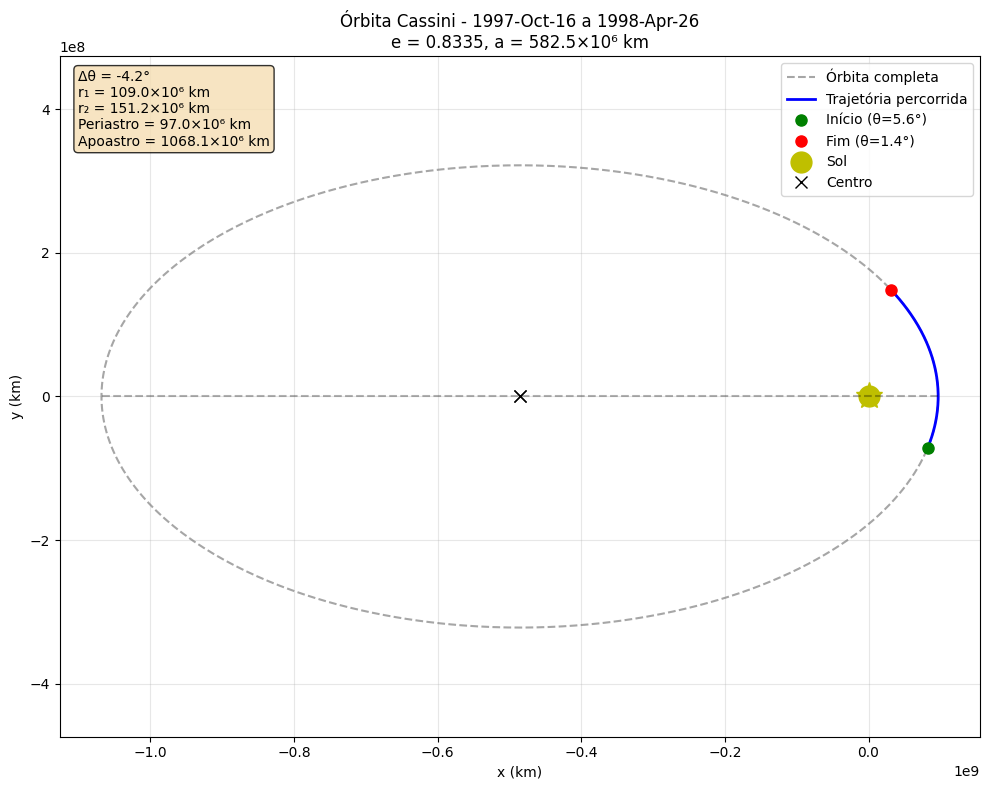

In [165]:
orbita4 = dados_da_orbita('1999-Jun-24', '1999-Aug-18', printa_dados=True, plota_orbita=True)


In [162]:
orbita5 = dados_da_orbita('1999-Aug-18', '2000-Dec-30', printa_dados=True, plota_orbita=False)



Parâmetros calculados entre 1999-Aug-18 e 2000-Dec-30:
Excentricidade: 9.267613083370192e-01
Semi-eixo maior:1.281182429915870e+09 km 
Momento angular: 4.898301926803517e+09 km^2/s 
Velocidade inicial 1999-Aug-18: vr = 2.454517110730655e+01 km/s, vt = 3.238597937310552e+01 km/s, v_total = 4.063640098042853e+01 km/s
Velocidade final 2000-Dec-30: vr = 1.441517040568420e+01 km/s, vt = 6.534426763625723e+00 km/s, v_total = 1.582706134928723e+01 km/s
Tempo real de viagem: 500.000000 dias
Tempo teórico de viagem: 364.772831 dias
Erro percentual: 27.045434 %



In [163]:
orbita6 = dados_da_orbita('2000-Dec-30', '2004-Jul-01', printa_dados=True, plota_orbita=False)

C:\Users\JoaoBento\AppData\Local\Temp\ipykernel_12588\1466728317.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mu * r * (1 + e * np.cos(theta)))


ValueError: math domain error